# Comparative Analysis
In this notebook, we compare ClaSS with different competitors regarding scalability.

In [1]:
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
import numpy as np

import pandas as pd

pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
sns.set_color_codes()

import Orange
import sys

sys.path.append("../")

In [3]:
from src.utils import load_combined_dataset
from src.clazz.window_size import suss

Let's choose a score for evaluation (F1 or Covering).

In [4]:
eval_score = "covering_score"

In [5]:
df_comb = load_combined_dataset()
df_comb['window_size'] = df_comb.time_series.apply(lambda ts: np.int64(suss(ts[:10_000])))
df_comb['ts_len'] = df_comb.time_series.apply(len)
# takes too much space
df_comb.drop("time_series", axis=1, inplace=True)
df_comb.head()

,name,window_size,change_points,ts_len
0,Adiac,22,"[572, 1012, 1232]",1408
1,ArrowHead,32,[753],1506
2,Beef,66,[705],1410
3,BeetleFly,34,[1280],2560
4,BirdChicken,48,[1280],2560


Let's load the scores from the different methods.

In [6]:
df_runtimes = pd.read_csv("../experiments/runtimes.csv")
df_throughput = pd.read_csv("../experiments/throughputs.csv")
df_scores = pd.read_csv("../experiments/scores.csv")

idx_sizes = np.argsort(df_comb.ts_len).to_numpy()
df_throughput

,name,dataset,ADWIN,HDDM,NEWMA,ChangeFinder,DDM,Window,FLOSS,ClaSS
0,TSSB,Adiac,4925.832634,7507.731684,5259.226057,871.556794,7317.326681,1319.958751,65.779946,83.188236
1,TSSB,ArrowHead,4689.835575,7668.414889,5195.970190,877.555896,7142.518378,1393.038507,69.045354,86.025142
2,TSSB,Beef,4735.198307,7686.017989,5083.279256,966.514720,7612.979861,1800.030639,65.592531,80.865038
3,TSSB,BeetleFly,4516.903098,7655.960285,5363.278304,881.178576,7150.837989,1344.947516,119.055868,141.992825
4,TSSB,BirdChicken,4602.991945,7671.791183,5172.239620,867.878985,7221.234944,1346.263068,118.670648,147.488547
5,TSSB,CBF,4892.467638,7792.207792,5138.086063,874.436398,7152.969227,1503.029544,44.931388,50.621404
6,UTSA,Cane,4607.022690,7600.666126,5170.911204,871.318922,7282.943728,1274.414342,245.318956,221.597636
7,TSSB,Car,4798.668885,7625.326095,5081.401085,885.803796,7267.168391,1406.307905,98.788731,117.036018
8,TSSB,Chinatown,5558.128763,9019.165727,5218.525766,875.305445,8353.637313,2165.869506,116.123226,1833.880951
9,TSSB,ChlorineConcentration,4556.126621,7651.865148,5754.053137,874.375126,7019.327671,1344.700920,343.022476,287.204824


Let's calculate the sum/mean/std score.

In [7]:
np.round((df_runtimes.iloc[:, 2:].sum(axis=0) / 60) / 60, 0)

ADWIN             32.0
HDDM              16.0
NEWMA             25.0
ChangeFinder     137.0
DDM               17.0
Window           142.0
FLOSS           1372.0
ClaSS            245.0
dtype: float64

In [8]:
np.round(df_throughput.mean(axis=0), 0)

/var/folders/5_/fv_bzq1n4n76j6l_jqgndj6c0000gn/T/ipykernel_4176/4030067798.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  np.round(df_throughput.mean(axis=0), 0)


ADWIN           4292.0
HDDM            7812.0
NEWMA           5088.0
ChangeFinder     924.0
DDM             7430.0
Window          1049.0
FLOSS            204.0
ClaSS            587.0
dtype: float64

In [9]:
df_throughput.std(axis=0)

/var/folders/5_/fv_bzq1n4n76j6l_jqgndj6c0000gn/T/ipykernel_4176/584956545.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_throughput.std(axis=0)


ADWIN           413.725473
HDDM            361.128427
NEWMA           236.720144
ChangeFinder    193.227381
DDM             432.819016
Window          248.620150
FLOSS           316.681563
ClaSS           265.424590
dtype: float64

Let's compute the wins per method.

In [10]:
ranks = df_runtimes.rank(1, method='min', ascending=True)
means = np.array(ranks.mean(axis=0))

In [11]:
for mean, name in zip(means, df_runtimes.columns[2:]):
    print(f"{name}:wins={ranks[ranks[name] == 1].shape[0]} rank={np.round(mean, 5)}")

ADWIN:wins=0 rank=3.97128
HDDM:wins=512 rank=1.13514
NEWMA:wins=0 rank=3.02872
ChangeFinder:wins=0 rank=5.87331
DDM:wins=80 rank=1.86486
Window:wins=0 rank=5.38851
FLOSS:wins=0 rank=7.85473
ClaSS:wins=0 rank=6.88345


Let's plot and output the ranks.

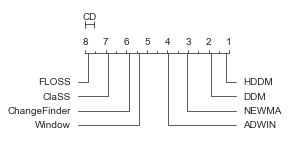

In [12]:
cd = Orange.evaluation.scoring.compute_CD(means, df_runtimes.shape[0])
Orange.evaluation.scoring.graph_ranks(means, df_runtimes.columns[2:], cd=cd, width=4, reverse=True, textspace=1,
                                      filename=f"../figures/cd_runtime.pdf")

Let's compute wins/losses against ClaSS.

In [13]:
selection = "ClaSS"

for rival in df_runtimes.columns[2:]:
    if rival == selection: continue

    df_pair = df_runtimes[[selection, rival]]
    pair_ranks = df_pair.rank(1, method='min', ascending=True)

    wins = pair_ranks[(pair_ranks[selection] == 1) & (pair_ranks[rival] == 2)].shape[0]
    losses = pair_ranks[(pair_ranks[selection] == 2) & (pair_ranks[rival] == 1)].shape[0]
    ties = pair_ranks[(pair_ranks[selection] == 1) & (pair_ranks[rival] == 1)].shape[0]

    assert wins + losses + ties == pair_ranks.shape[0]

    print(f"{selection} vs {rival}: (wins/ties/losses): {wins}/{ties}/{losses}")

ClaSS vs ADWIN: (wins/ties/losses): 0/0/592
ClaSS vs HDDM: (wins/ties/losses): 0/0/592
ClaSS vs NEWMA: (wins/ties/losses): 0/0/592
ClaSS vs ChangeFinder: (wins/ties/losses): 92/0/500
ClaSS vs DDM: (wins/ties/losses): 0/0/592
ClaSS vs Window: (wins/ties/losses): 18/0/574
ClaSS vs FLOSS: (wins/ties/losses): 551/0/41


/var/folders/5_/fv_bzq1n4n76j6l_jqgndj6c0000gn/T/ipykernel_4176/3871166872.py:8: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(fontsize)
/var/folders/5_/fv_bzq1n4n76j6l_jqgndj6c0000gn/T/ipykernel_4176/3871166872.py:11: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(fontsize)


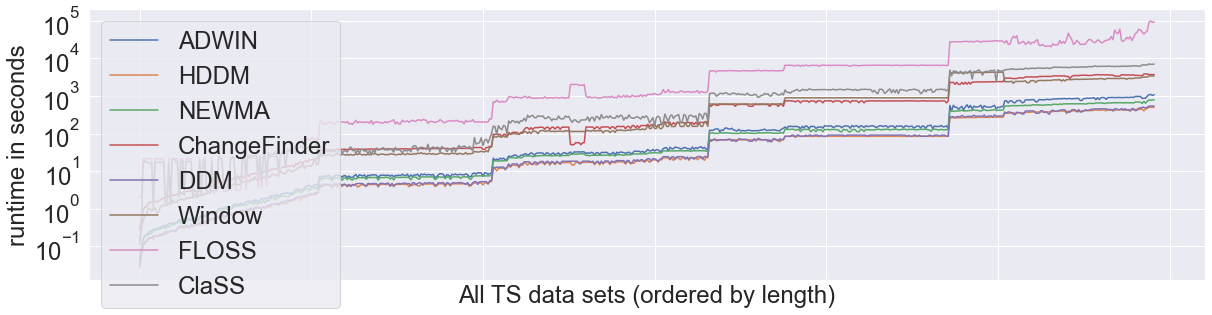

In [14]:
fontsize = 24
_, ax = plt.subplots(1, figsize=(20, 5))

for name in df_runtimes.columns[2:]:
    ax.plot(df_runtimes[name].to_numpy()[idx_sizes], label=name)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)

ax.tick_params(
    axis='x',
    which='both',
    labelbottom=False,
    labelleft=False
)
ax.legend(loc=2, prop={'size': fontsize})
ax.set_xlabel("All TS data sets (ordered by length)", fontsize=fontsize)
ax.set_ylabel("runtime in seconds", fontsize=fontsize)

ax.set_yscale('log')

names = df_runtimes.name.to_numpy().tolist()
names = np.array(names)[idx_sizes]

plt.savefig(f"../figures/runtime.pdf", bbox_inches="tight")

/var/folders/5_/fv_bzq1n4n76j6l_jqgndj6c0000gn/T/ipykernel_4176/1332989742.py:16: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(fontsize)
/var/folders/5_/fv_bzq1n4n76j6l_jqgndj6c0000gn/T/ipykernel_4176/1332989742.py:19: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(fontsize)


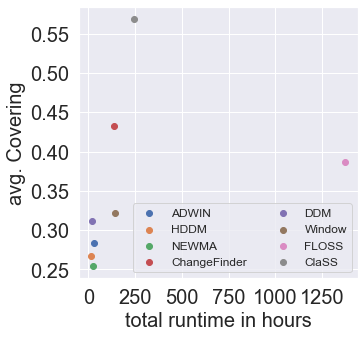

In [15]:
fontsize = 20

_, ax = plt.subplots(1, figsize=(5, 5))

for competitor in df_runtimes.columns[2:]:
    ax.scatter(((df_runtimes[competitor].sum() / 60) / 60), df_scores[competitor].mean(), label=competitor)

ax.set_xlabel("total runtime in hours", fontsize=fontsize)
ax.set_ylabel("avg. Covering", fontsize=fontsize)

ax.legend(prop={'size': 12}, ncol=2, loc=4)

ax.set_xticks(np.arange(0, 1400, 250))

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)

plt.savefig(f"../figures/runtime_covering.pdf", bbox_inches="tight")

In [16]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression().fit(df_comb.ts_len.to_numpy().reshape(-1, 1), df_runtimes.ClaSS.to_numpy().reshape(-1, 1))
y_min, y_max = lr.predict(np.array([df_comb.ts_len.min(), df_comb.ts_len.max()]).reshape(-1, 1)).flatten()

# mean deviation predicted / actual ts length
np.mean(np.abs(1 - lr.predict(df_comb.ts_len.to_numpy().reshape(-1, 1)).flatten() / df_runtimes.ClaSS.to_numpy()))

2.2699909393481703

/var/folders/5_/fv_bzq1n4n76j6l_jqgndj6c0000gn/T/ipykernel_4176/3332897640.py:12: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(fontsize)
/var/folders/5_/fv_bzq1n4n76j6l_jqgndj6c0000gn/T/ipykernel_4176/3332897640.py:15: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(fontsize)


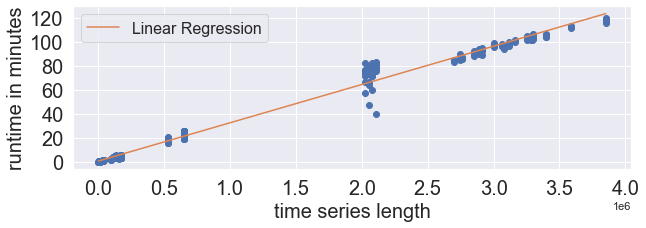

In [17]:
fontsize = 20

_, ax = plt.subplots(1, figsize=(10, 3))
ax.scatter(df_comb.ts_len, df_runtimes.ClaSS / 60)

ax.plot([df_comb.ts_len.min(), df_comb.ts_len.max()], [y_min / 60, y_max / 60], c="C1", label="Linear Regression")

ax.set_xlabel("time series length", fontsize=fontsize)
ax.set_ylabel("runtime in minutes", fontsize=fontsize)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)

ax.legend(loc=2, prop={'size': fontsize - 4})

plt.savefig(f"../figures/runtime_length.pdf", bbox_inches="tight")

/var/folders/5_/fv_bzq1n4n76j6l_jqgndj6c0000gn/T/ipykernel_4176/2734770154.py:9: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(fontsize)
/var/folders/5_/fv_bzq1n4n76j6l_jqgndj6c0000gn/T/ipykernel_4176/2734770154.py:12: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(fontsize)


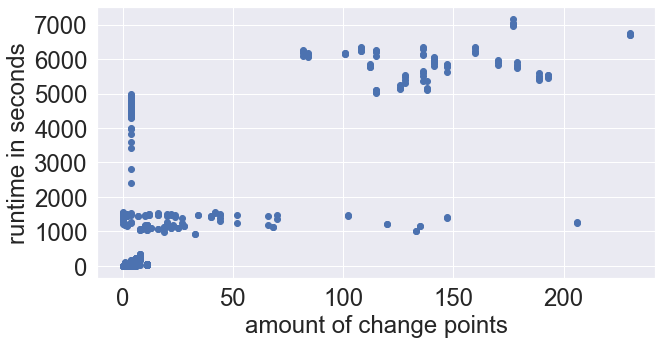

In [18]:
fontsize = 24

_, ax = plt.subplots(1, figsize=(10, 5))
ax.scatter(df_comb["change_points"].apply(len), df_runtimes.ClaSS)
ax.set_xlabel("amount of change points", fontsize=24)
ax.set_ylabel("runtime in seconds", fontsize=24)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)

plt.savefig(f"../figures/runtime_cps.pdf", bbox_inches="tight")

/var/folders/5_/fv_bzq1n4n76j6l_jqgndj6c0000gn/T/ipykernel_4176/3989424446.py:9: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(fontsize)
/var/folders/5_/fv_bzq1n4n76j6l_jqgndj6c0000gn/T/ipykernel_4176/3989424446.py:12: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(fontsize)


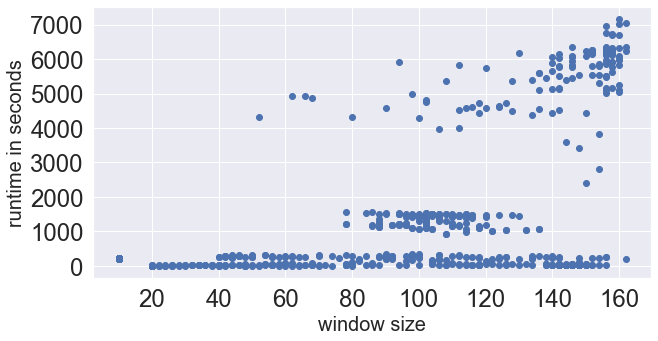

In [19]:
fontsize = 24

_, ax = plt.subplots(1, figsize=(10, 5))
ax.scatter(df_comb.window_size, df_runtimes.ClaSS)
ax.set_xlabel("window size", fontsize=20)
ax.set_ylabel("runtime in seconds", fontsize=20)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)

plt.savefig(f"../figures/runtime_window.pdf", bbox_inches="tight")

/var/folders/5_/fv_bzq1n4n76j6l_jqgndj6c0000gn/T/ipykernel_4176/3708166289.py:10: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(fontsize)
/var/folders/5_/fv_bzq1n4n76j6l_jqgndj6c0000gn/T/ipykernel_4176/3708166289.py:13: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(fontsize)


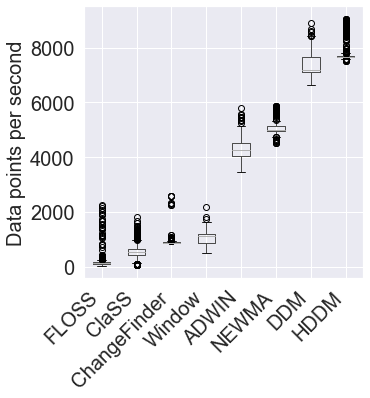

In [20]:
fontsize = 20
_, ax = plt.subplots(figsize=(5, 5))

order = ["FLOSS", "ClaSS", "ChangeFinder", "Window", "ADWIN", "NEWMA", "DDM", "HDDM"]

df_throughput[order].boxplot(ax=ax, rot=90)
ax.set_ylabel("Data points per second", fontsize=fontsize)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)

ax.set_xticklabels(order, rotation=45, ha="right")
plt.savefig(f"../figures/bp_throughput.pdf", bbox_inches="tight")